In [771]:
#load pacakges
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(splines))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggfortify))
suppressPackageStartupMessages(library(lme4))
suppressPackageStartupMessages(library(nlme))
#suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(mixOmics))
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(caTools))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library("BiocParallel"))

In [772]:
# import data
# client_information, sex, age
platform <- "SageMaker"
if ("SageMaker" == platform) {
    arivaleDir <- "../data/arivale_snapshot_ISB_2019-05-10_0053"
    frailtyDir <- "../data/frailty"
} else {
    arivaleDir <- "/shared-data/snapshots/arivale_snapshot_ISB_2019-05-10_0053/"
    frailtyDir <- "/shared-libs/useful-files/frailty_measures_kanelab/FI_workshop_040124"
}
client_info = read.csv(file.path(arivaleDir,"clients.tsv"), sep = "\t", skip = 13) %>%
              dplyr::select(public_client_id, age)
# genetic principal component
genetic_pc = read.csv(file.path(arivaleDir,"genetics_ancestry.tsv"), sep = "\t", skip = 13) %>%
              dplyr::select(public_client_id, paste0("PC", 1:4))
# frailty index longitudinal, inlcuding days_since_first_draw
lab_fi_longitudinal = read.csv(file.path(frailtyDir,"lab_fi_longitudinal_040124.csv"))
#unique(lab_fi_longitudinal$public_client_id) %>% length() 4874

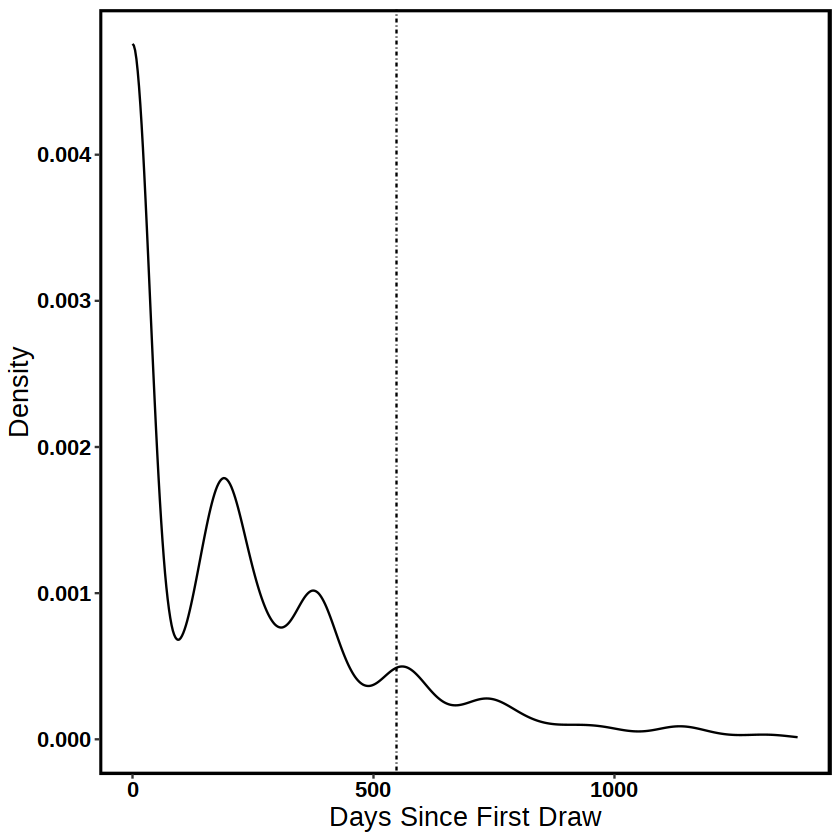

In [773]:
# initial assessment of the data by visualization 
# distribution of days since first draw
options(jupyter.plot_scale=1,
        width=200,
        repr.matrix.max.cols=200,
        repr.matrix.max.rows=Inf)
ggplot2::theme_set(theme_bw() + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        plot.title = element_text(hjust = 0.5), text = element_text(size = 16), 
        panel.border = element_rect(colour = "black", fill = NA, size = 1.2),
        axis.text.y = element_text(face = "bold", color = "black"),
        axis.text.x = element_text(face = "bold", color = "black")))
ggplot(data = lab_fi_longitudinal,
       aes(x = as.numeric(days_since_first_draw))) +
    geom_density() +
    labs(x = "Days Since First Draw",
        y = "Density") +
    geom_vline(xintercept = 365.25/12*18, lty = 4)

In [774]:
lab_fi_longitudinal$draw <- round(lab_fi_longitudinal$days_since_first_draw / (365.25/2))
drawsByClient <- table(lab_fi_longitudinal$public_client_id, lab_fi_longitudinal$draw)
firstThree <- drawsByClient[,'0'] == 1 & drawsByClient[,'1'] == 1 & drawsByClient[,'2'] == 1
simpleClient = names(firstThree)[firstThree]

In [775]:
# select a 18 months period where an id has greater than 3 visits and use first 3 visits. 
month_threshold = lab_fi_longitudinal %>%
                  filter(as.numeric(days_since_first_draw) <= 365.25/12*18)
freq_above3 = table(month_threshold$public_client_id) %>% 
              as.data.frame() %>%
              filter(Freq >= 3) #nrow(freq_above3) 1605 participants remain
first3_visit_dat = month_threshold %>%
                   filter(public_client_id %in% freq_above3$Var1) %>%
                   group_by(public_client_id) %>%
                   arrange(days_since_first_draw) %>%
                   filter(row_number() %in% c(1, 2, 3)) %>%
                   filter(public_client_id %in% simpleClient)

In [776]:
# baseline fi (first draw)
bl_fi_dat = first3_visit_dat %>%
        group_by(public_client_id) %>%
               arrange(days_since_first_draw) %>%
               filter(row_number() == 1) %>% 
               mutate(bl_fi = lab_fi) %>%
               dplyr::select(public_client_id, bl_fi)
# add bl_fi and stratification by sex
female_bl_fi_dat = first3_visit_dat %>%
                   filter(sex == "F") %>%
                   merge(., bl_fi_dat, by = "public_client_id") %>%
                   merge(., client_info, by = "public_client_id") %>%
                   merge(., genetic_pc, by = "public_client_id") %>%
                   arrange(public_client_id, days_since_first_draw)
#nrow 2757, length(unique(female_bl_fi_dat$public_client_id)) 919
male_bl_fi_dat = first3_visit_dat %>%
                   filter(sex == "M") %>%
                   merge(., bl_fi_dat, by = "public_client_id") %>%
                   merge(., client_info, by = "public_client_id") %>%
                   merge(., genetic_pc, by = "public_client_id") %>%
                   arrange(public_client_id, days_since_first_draw)
#nrow 2055, length(unique(male_bl_fi_dat$public_client_id)) 685
mix_bl_fi_dat = rbind(female_bl_fi_dat, male_bl_fi_dat) %>% as.data.frame()

In [777]:
mix_bl_fi_dat_base = mix_bl_fi_dat %>%
                    group_by(public_client_id) %>% 
                    arrange(days_since_first_draw) %>%
                    filter(row_number() == 1)

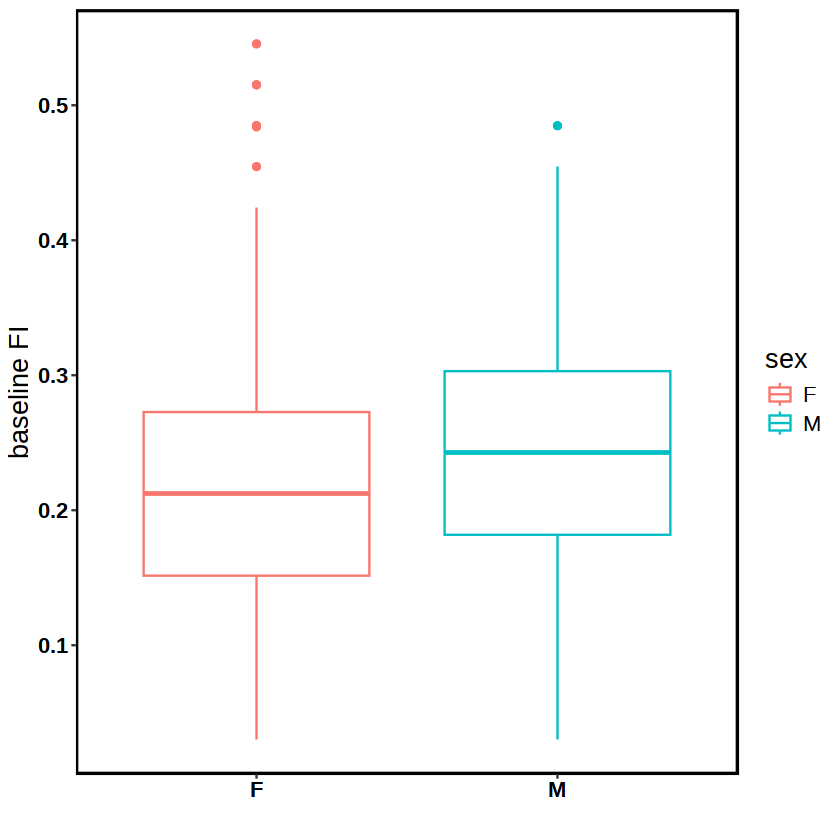

In [778]:
ggplot(data = mix_bl_fi_dat_base,
       aes(x = sex,
           y = lab_fi,
           color = sex)) +
   geom_boxplot() +
   labs(x = "",
        y = "baseline FI")

`geom_smooth()` using formula = 'y ~ x'


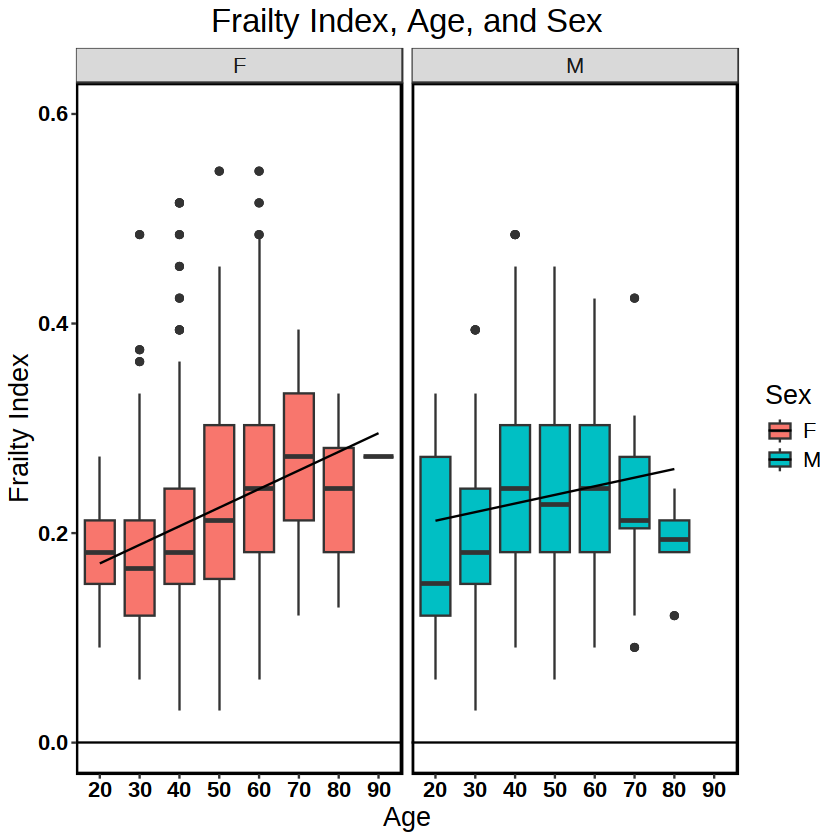

In [779]:
groupWidth <- 10
ageGroup <- groupWidth*round(mix_bl_fi_dat$age.x/groupWidth)
ggplot(data = mix_bl_fi_dat,
       aes(x    = as.factor(ageGroup),
           y    = bl_fi,
           fill = as.factor(sex))) +
       ylim(0.00, 0.60) + 
       geom_boxplot() +
       labs(x    = "Age", 
            y    = "Frailty Index") +
       facet_wrap(~ as.factor(sex)) +
       geom_smooth(aes(group = as.factor(sex)),
                   method = "lm",
                   se = FALSE,
                   linewidth = 1/2,
                   color = 'black') + 
       geom_hline(yintercept = 0) +
       labs(fill = "Sex",
            color = "Trend",
            title = "Frailty Index, Age, and Sex")



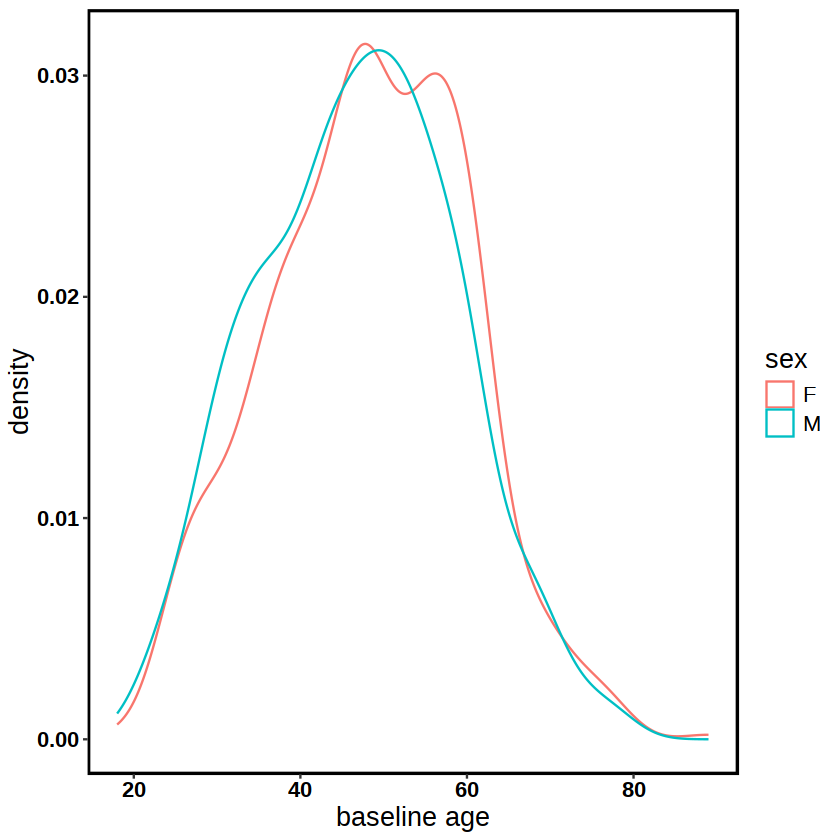

In [780]:
ggplot(data = mix_bl_fi_dat_base,
       aes(x = age.x,
           color = sex)) +
   geom_density() +
   labs(x = "baseline age")

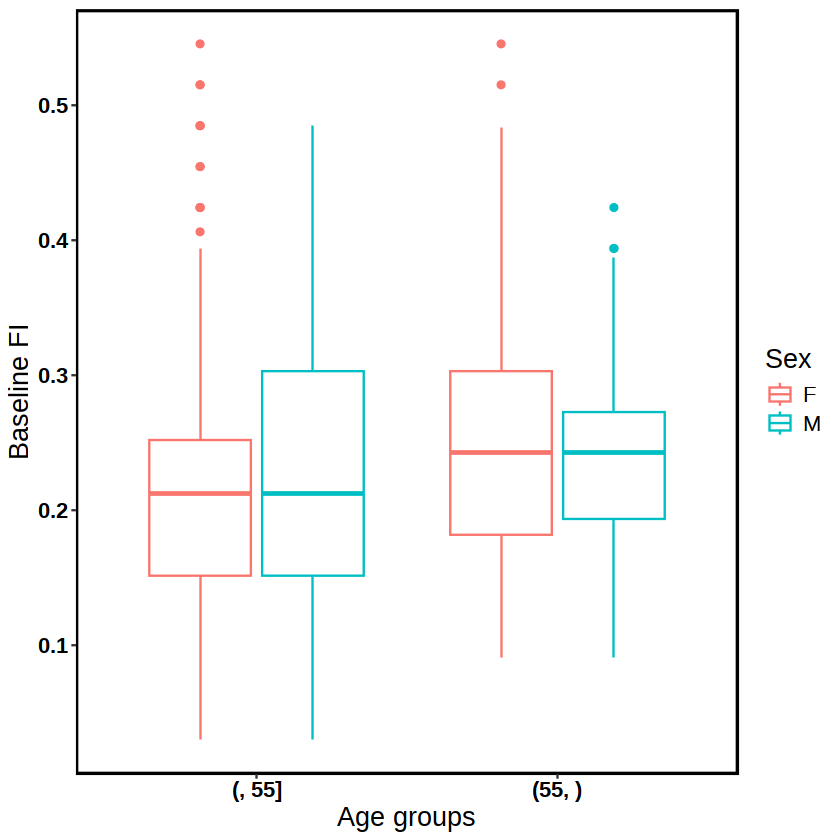

In [781]:
mix_bl_fi_dat_base = mix_bl_fi_dat_base %>%
                mutate(age_bin = ifelse(age.x > 55, 1, 0))

ggplot(data = mix_bl_fi_dat_base,
       aes(x = as.factor(age_bin),
           y = bl_fi,
          color = as.factor(sex))) +
   geom_boxplot() + 
   scale_x_discrete(labels = c("0" = "(, 55]",
                               "1" = "(55, )")) +
   labs(x = "Age groups", 
        y = "Baseline FI",
        color = "Sex")

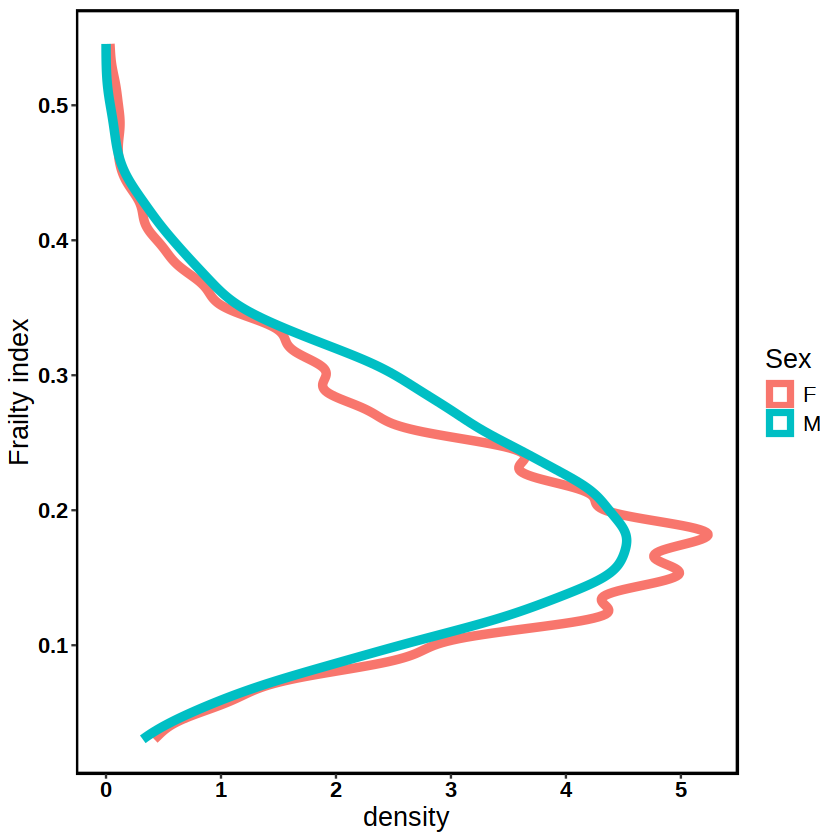

In [782]:
# fi plots, density
ggplot(data = mix_bl_fi_dat,
       aes(x = lab_fi)) +
   geom_density(aes(group = as.factor(sex),
                   color = as.factor(sex)),
               linewidth = 2) +
   labs(x = "Frailty index",
       color = "Sex") +
   coord_flip()

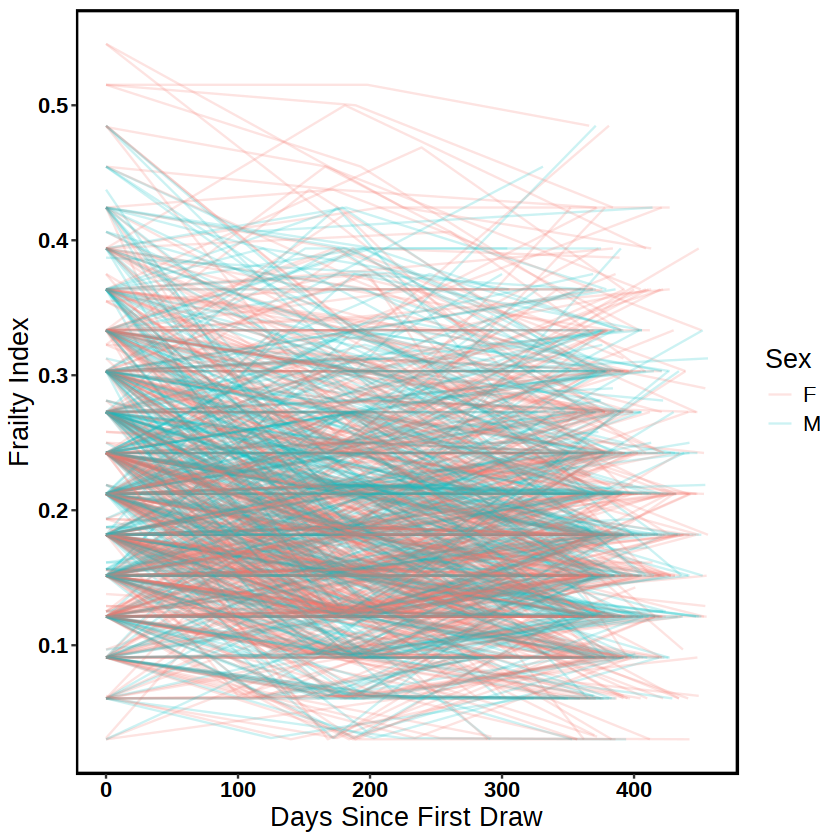

In [783]:
# fi plots, dynamics 
ggplot(data = mix_bl_fi_dat,
       aes(x = days_since_first_draw,
           y = lab_fi,
           color = as.factor(sex))) +
   geom_line(aes(group = as.factor(public_client_id)), alpha = 0.2) +
   labs(x = "Days Since First Draw",
        y = "Frailty Index",
       color = "Sex")

In [791]:
# get time knots (df = 3), attached to df, scale numeric variables
time_knots_female = splines::ns(female_bl_fi_dat$days_since_first_draw, knots = c(182.625, 365.25), df = 3)
time_knots_male = splines::ns(male_bl_fi_dat$days_since_first_draw, knots = c(182.625, 365.25), df = 3)
female_bl_fi_dat_all = female_bl_fi_dat %>%
                      mutate(t1 = time_knots_female[, 1],
                             t2 = time_knots_female[, 2],
                             t3 = time_knots_female[, 3]) %>%
                      mutate(base_age = age.x) %>%
                      mutate_at(c("PC1", "PC2", "PC3", "PC4", 
                                  "t1", "t2", "t3", "base_age"), ~scale(.)[, 1])
male_bl_fi_dat_all = male_bl_fi_dat %>%
                      mutate(t1 = time_knots_male[, 1],
                             t2 = time_knots_male[, 2],
                             t3 = time_knots_male[, 3]) %>%
                      mutate(base_age = age.x) %>%
                      mutate_at(c("PC1", "PC2", "PC3", "PC4",
                                  "t1", "t2", "t3", "base_age"), ~scale(.)[, 1])

In [793]:
colnames(female_bl_fi_dat_all)

[1] "public_client_id"      "X"                     "id_days"               "days_in_program"       "days_since_first_draw" "sex"                   "race"                  "age.x"                
 [9] "CHEM1"                 "CHEM2"                 "CHEM3"                 "CHEM4"                 "CHEM5"                 "CHEM6"                 "CHEM7"                 "CHEM8"                
[17] "CHEM9"                 "CHEM10"                "CHEM11"                "CHEM12"                "CHEM13"                "CHEM14"                "CHEM15"                "CHEM16"               
[25] "CHEM17"                "CHEM18"                "CHEM19"                "CHEM20"                "CHEM21"                "CHEM22"                "CHEM23"                "CHEM24"               
[33] "CHEM25"                "CHEM26"                "CHEM27"                "CHEM28"                "CHEM29"                "BP1"                   "BP2"                   "BP3"                  
[41] "BP4"                   "BP5"                   "num_na"                "lab_fi"                "lab_fi_sum"            "draw"                  "bl_fi"                 "age.y"                
[49] "PC1"                   "PC2"                   "PC3"                   "PC4"                   "t1"                    "t2"                    "t3"                    "base_age"

In [794]:
colnames(male_bl_fi_dat_all)

[1] "public_client_id"      "X"                     "id_days"               "days_in_program"       "days_since_first_draw" "sex"                   "race"                  "age.x"                
 [9] "CHEM1"                 "CHEM2"                 "CHEM3"                 "CHEM4"                 "CHEM5"                 "CHEM6"                 "CHEM7"                 "CHEM8"                
[17] "CHEM9"                 "CHEM10"                "CHEM11"                "CHEM12"                "CHEM13"                "CHEM14"                "CHEM15"                "CHEM16"               
[25] "CHEM17"                "CHEM18"                "CHEM19"                "CHEM20"                "CHEM21"                "CHEM22"                "CHEM23"                "CHEM24"               
[33] "CHEM25"                "CHEM26"                "CHEM27"                "CHEM28"                "CHEM29"                "BP1"                   "BP2"                   "BP3"                  
[41] "BP4"                   "BP5"                   "num_na"                "lab_fi"                "lab_fi_sum"            "draw"                  "bl_fi"                 "age.y"                
[49] "PC1"                   "PC2"                   "PC3"                   "PC4"                   "t1"                    "t2"                    "t3"                    "base_age"

In [795]:
female_clients <- unique(female_bl_fi_dat_all$public_client_id)
nth <- female_bl_fi_dat_all[,c('public_client_id','days_since_first_draw')]
nth$seq <- rep(0,dim(nth)[1])
for (id in female_clients) {
    s <- which(nth$public_client_id == id)
    nth$seq[s] <- c(1:length(s))    
}

In [811]:
# boxplot(split(nth$days_since_first_draw,nth$seq))
quarterYear <- 365/4
halfYear <- 2*quarterYear
nl <- function() { cat(noquote("\n")) }

In [796]:
firsts <- nth$days_since_first_draw[nth$seq == 1]
u1 <- median(firsts)
deltas <- firsts - u1
outs <- which(abs(deltas) > quarterYear)
nl() ; nl()
cat(noquote(paste("Median", u1, "days, ", length(outs),"outliers among",length(firsts), "female clients"))) ; nl()
dMonths <- round(deltas / (365.25/12))
xtabs(~ dMonths)

seconds <- nth$days_since_first_draw[nth$seq == 2]
u2 <- median(seconds)
deltas <- seconds - u2
outs <- which(abs(deltas) > quarterYear)
nl() ; nl()
cat(noquote(paste("Median", u2, "days, ", length(outs),"outliers among",length(seconds), "female clients")))  ; nl()
dMonths <- round(deltas / (365.25/12))
xtabs(~ dMonths)

thirds <- nth$days_since_first_draw[nth$seq == 3]
u3 <- median(thirds)
deltas <- thirds - u3
outs <- which(abs(deltas) > quarterYear)
nl() ; nl()
cat(noquote(paste("Median", u3, "days, ", length(outs),"outliers among",length(thirds), "female clients"))) ; nl()
dMonths <- round(deltas / (365.25/12))
xtabs(~ dMonths)



Median 0 days,  0 outliers among 674 female clients


dMonths
  0 
674 



Median 182 days,  0 outliers among 674 female clients


dMonths
 -3  -2  -1   0   1   2   3 
  6  47 120 332 125  38   6 



Median 372 days,  14 outliers among 674 female clients


dMonths
 -3  -2  -1   0   1   2   3 
 51  51  81 280 125  74  12 

In [797]:
male_clients <- unique(male_bl_fi_dat_all$public_client_id)
nth <- male_bl_fi_dat_all[,c('public_client_id','days_since_first_draw')]
nth$seq <- rep(0,dim(nth)[1])
for (id in male_clients) {
    s <- which(nth$public_client_id == id)
    nth$seq[s] <- c(1:length(s))    
}

In [798]:
# boxplot(split(nth$days_since_first_draw,nth$seq))
firsts <- nth$days_since_first_draw[nth$seq == 1]
u1 <- median(firsts)
deltas <- firsts - u1
outs <- which(abs(deltas) > quarterYear)
nl() ; nl()
cat(noquote(paste("Median", u1, "days, ", length(outs),"outliers among",length(firsts), "male clients"))) ; nl()
dMonths <- sign(deltas)*trunc(deltas / (365.25/12))
xtabs(~ dMonths)

seconds <- nth$days_since_first_draw[nth$seq == 2]
u2 <- median(seconds)
deltas <- seconds - u2
outs <- which(abs(deltas) > quarterYear)
nl() ; nl()
cat(noquote(paste("Median", u2, "days, ", length(outs),"outliers among",length(seconds), "male clients"))) ; nl()
dMonths <- round(deltas / (365.25/12))
xtabs(~ dMonths)

thirds <- nth$days_since_first_draw[nth$seq == 3]
u3 <- median(thirds)
deltas <- thirds - u3
outs <- which(abs(deltas) > quarterYear)
nl() ; nl()
print(noquote(paste("Median", u3, "days, ", length(outs),"outliers among",length(thirds), "male clients"))) ; nl()
dMonths <- round(deltas / (365.25/12))
xtabs(~ dMonths)




Median 0 days,  0 outliers among 452 male clients


dMonths
  0 
452 



Median 185 days,  1 outliers among 452 male clients


dMonths
 -3  -2  -1   0   1   2   3 
  4  40  83 229  74  21   1 



[1] Median 371 days,  7 outliers among 452 male clients



dMonths
 -3  -2  -1   0   1   2   3 
 31  46  50 205  76  36   8 

In [799]:
# multiple lmm comparison 
lmm_f1 = lmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (t1 |`public_client_id`),
                 data = female_bl_fi_dat_all)
lmm_f2 = glmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (1 + t1 |`public_client_id`), 
                 family = Gamma(link = "log"), 
                 data = female_bl_fi_dat_all)
lmm_f3 = glmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (1 |`public_client_id`), 
                 family = Gamma(link = "log"), 
                 data = female_bl_fi_dat_all) # cannot perform link = "identity"

AIC(lmm_f1, lmm_f2, lmm_f3) # choose the least AIC
BIC(lmm_f1, lmm_f2, lmm_f3) # BIC and AIC only differ in how they account for model size (df)

boundary (singular) fit: see help('isSingular')



,df,AIC
,<dbl>,<dbl>
lmm_f1,13,-5203.872
lmm_f2,13,-6068.414
lmm_f3,11,-5825.389


,df,BIC
,<dbl>,<dbl>
lmm_f1,13,-5130.918
lmm_f2,13,-5995.461
lmm_f3,11,-5763.658


In [800]:
# lmm 
set.seed(2024)
lmer_res_f = glmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (1 + t1 |`public_client_id`), 
                 family = Gamma(link = "log"), 
                 data = female_bl_fi_dat_all)
set.seed(2024)
lmer_res_m = glmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (1 + t1 |`public_client_id`), 
                 family = Gamma(link = "log"), 
                 data = male_bl_fi_dat_all)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00222995 (tol = 0.002, component 1)”


In [846]:
# for each id, we estimate the a series of days (new_time) with base_age and PCs
# get mean for each (days_since_first_draw) and plot
new_time = female_bl_fi_dat_all %>%
           dplyr::select(days_since_first_draw, t1, t2, t3) %>%
           distinct() %>%
           arrange(days_since_first_draw)
female_id_distinct = female_bl_fi_dat_all %>%
                     dplyr::select(public_client_id, base_age, PC1, PC2, PC3, PC4) %>%
                     distinct()
# creat new df to fit the model
female_id_forpred = female_id_distinct %>% 
                    dplyr::slice(rep(1:n(), each = nrow(new_time))) %>%
                    cbind(., new_time[rep(1:nrow(new_time), length(unique(female_id_distinct$public_client_id))), ]) %>%
                    as.data.frame()
male_id_distinct = male_bl_fi_dat_all %>%
                   dplyr::select(public_client_id, base_age, PC1, PC2, PC3, PC4) %>%
                     distinct()
male_id_forpred = male_id_distinct %>% 
                    dplyr::slice(rep(1:n(), each = nrow(new_time))) %>%
                    cbind(., new_time[rep(1:nrow(new_time), length(unique(male_id_distinct$public_client_id))), ]) %>%
                    as.data.frame()

In [847]:
# add estimate fi and merge female and males
female_id_forpred_est = female_id_forpred %>%
                        mutate(est = exp(predict(lmer_res_f, newdata = female_id_forpred[, -7])), #exclude column 'days_since...'
                              sex = rep("F", nrow(.)))
male_id_forpred_est = male_id_forpred %>%
                        mutate(est = exp(predict(lmer_res_m, newdata = male_id_forpred[, -7])),
                              sex = rep("M", nrow(.)))
mix_id_pred = rbind(female_id_forpred_est, male_id_forpred_est) %>% as.data.frame()

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


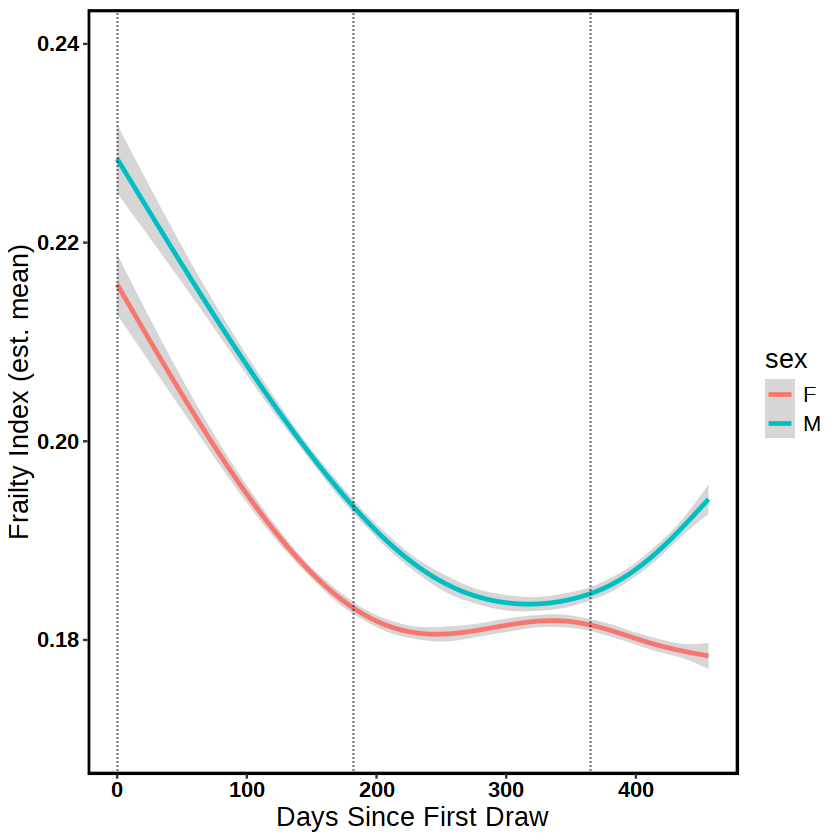

In [863]:
ggplot(data = mix_id_pred,
       aes(x = days_since_first_draw,
           y = as.numeric(est))) +
        geom_smooth(aes(group = sex,
                       color = as.factor(sex))) +
        coord_cartesian(ylim = c(0.17,0.24)) +
       geom_vline(xintercept = c(0:2)*halfYear, linetype = "dotted") +
    labs(x = "Days Since First Draw",
        y = "Frailty Index (est. mean)",
        color = "sex")

In [864]:
## age group separate models
female_below55_dat = female_bl_fi_dat_all %>%  filter(age.x <= 55) 
female_above55_dat = female_bl_fi_dat_all %>% filter(age.x > 55) 
male_below55_dat = male_bl_fi_dat_all %>% filter(age.x <= 55) 
male_above55_dat = male_bl_fi_dat_all %>% filter(age.x > 55) 

In [902]:
length(unique(female_below55_dat$public_client_id))
length(unique(female_above55_dat$public_client_id))
length(unique(male_below55_dat$public_client_id))
length(unique(male_above55_dat$public_client_id))


[1] 472

[1] 202

[1] 343

[1] 109

In [865]:
lmer_res_fbelow55 = glmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (1 + t1 |`public_client_id`), 
                 family = Gamma(link = "log"), 
                 data = female_below55_dat)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00818451 (tol = 0.002, component 1)”


In [866]:
lmer_res_fabove55 = glmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (1 + t1 |`public_client_id`), 
                 family = Gamma(link = "log"), 
                 data = female_above55_dat)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.443328 (tol = 0.002, component 1)”


In [867]:
lmer_res_mbelow55 = glmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (1 + t1 |`public_client_id`), 
                 family = Gamma(link = "log"), 
                 data = male_below55_dat)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00211783 (tol = 0.002, component 1)”


In [868]:
lmer_res_mabove55 = glmer(lab_fi ~ t1 + t2 + t3 + base_age + PC1 + PC2 + PC3 + PC4 + (1 + t1 |`public_client_id`), 
                 family = Gamma(link = "log"), 
                 data = male_above55_dat)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0325078 (tol = 0.002, component 1)”


In [904]:
#type_lst = c("Female (, 55]", "Female (55, )", "Male (, 55]", "Male (55, )")

female_id_forpred_below55 = female_id_forpred %>% 
                    filter(public_client_id %in% unique(female_below55_dat$'public_client_id'))
female_id_forpred_above55 = female_id_forpred %>% 
                    filter(public_client_id %in% unique(female_above55_dat$'public_client_id'))

female_below55_forpred_est = female_id_forpred_below55 %>%
                        mutate(est = exp(predict(lmer_res_fbelow55, newdata = female_id_forpred_below55[, -7])), #exclude column 'days_since...'
                               sex = "F",
                              type = rep("55-", nrow(.)))
female_above55_forpred_est = female_id_forpred_above55 %>%
                        mutate(est = exp(predict(lmer_res_fabove55, newdata = female_id_forpred_above55[, -7])),
                               sex = "F",
                              type = rep("56+", nrow(.)))


In [905]:
male_id_forpred_below55 = male_id_forpred %>% 
                    filter(public_client_id %in% unique(male_below55_dat$'public_client_id'))
male_id_forpred_above55 = male_id_forpred %>% 
                    filter(public_client_id %in% unique(male_above55_dat$'public_client_id'))
male_below55_forpred_est = male_id_forpred_below55 %>%
                        mutate(est = exp(predict(lmer_res_mbelow55,
                                                 newdata = male_id_forpred_below55[, -7])), #exclude column 'days_since...'
                               sex = "M",
                              type = rep("55-", nrow(.)))
male_above55_forpred_est = male_id_forpred_above55 %>%
                        mutate(est = exp(predict(lmer_res_mabove55,
                                                 newdata = male_id_forpred_above55[, -7])),
                               sex = "M",
                              type = rep("56+", nrow(.)))
mix_id_pred = Reduce(rbind, list(female_below55_forpred_est, 
                                 female_above55_forpred_est,
                                 male_below55_forpred_est,
                                 male_above55_forpred_est)) %>% as.data.frame()

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


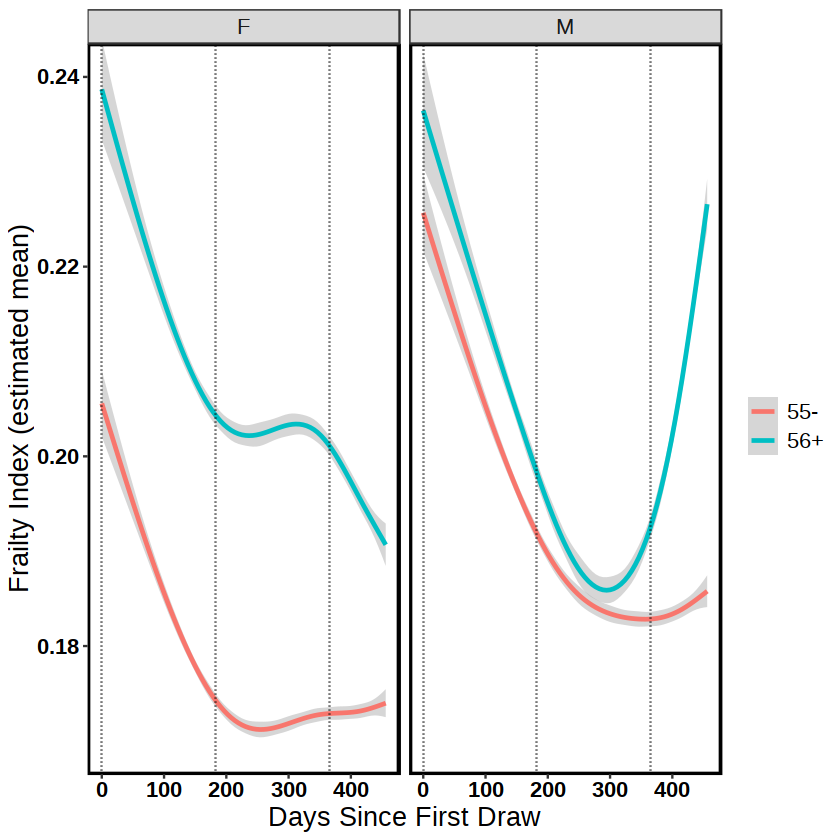

In [906]:
ggplot( data = mix_id_pred,
        aes(x = days_since_first_draw,
           y = est)) +
        geom_smooth(aes(group = as.factor(type),
                       color = as.factor(type))) +
        coord_cartesian(ylim = c(0.17,0.24)) +
        geom_vline(xintercept = c(0:2)*halfYear, linetype = "dotted") +
        facet_wrap(~ as.factor(sex)) +
        labs(x = "Days Since First Draw",
             y = "Frailty Index (estimated mean)",
             color = "")

In [872]:
prs_res = read.table("/shared-libs/useful-files/frailty_measures_kanelab/FI_workshop_040124/arivale.wgs.PLS2.prs.out", header = TRUE)
id_match = read.table("/shared-libs/useful-files/frailty_measures_kanelab/FI_workshop_040124/allGenomeIDs.txt", header = TRUE)
dl90cs_prs = merge(id_match, prs_res, by.x = "genome_id", by.y = "id") %>%
           dplyr::select(public_client_id, dl90_cs)

mix_bl_fi_dat_prs = merge(mix_bl_fi_dat, dl90cs_prs, by = "public_client_id") %>% as.data.frame() %>%
                    dplyr::select(public_client_id, sex, bl_fi, age.x, dl90_cs) %>%
                    unique()

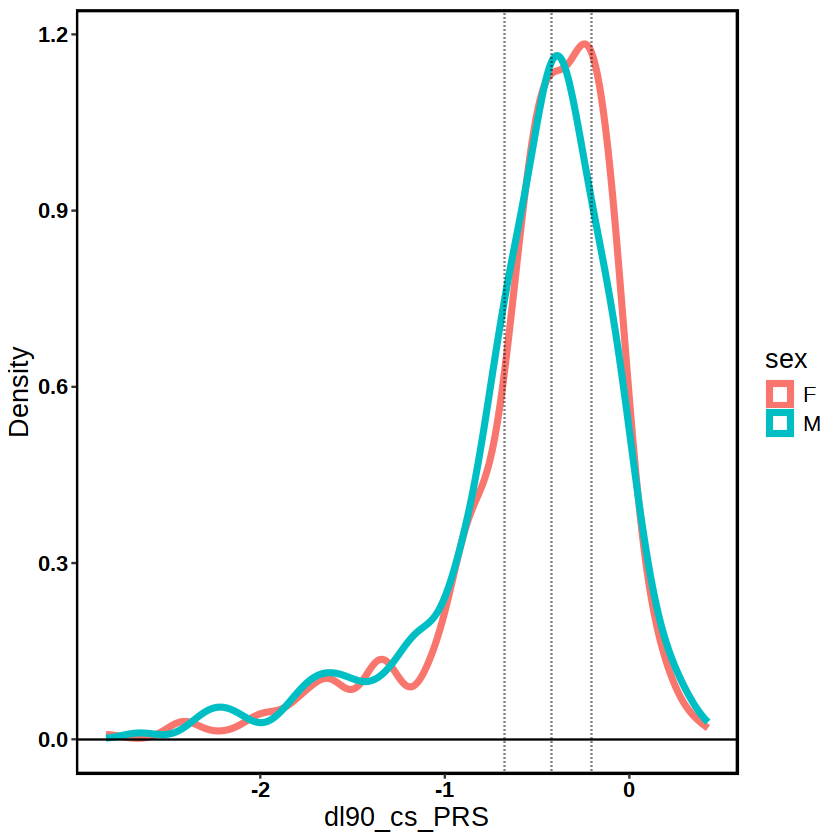

In [873]:
# PRS distribution by sex
prsQuartiles <- quantile(mix_bl_fi_dat_prs$dl90_cs,prob=c(1:3)/4)
ggplot(data = mix_bl_fi_dat_prs,
       aes(x = dl90_cs,
           color = sex)) +
       geom_density(linewidth = 1.5) +
       geom_vline(xintercept = prsQuartiles, linetype = "dotted") +
       geom_hline(yintercept = 0) +
    labs(x = "dl90_cs_PRS",
         y = "Density")

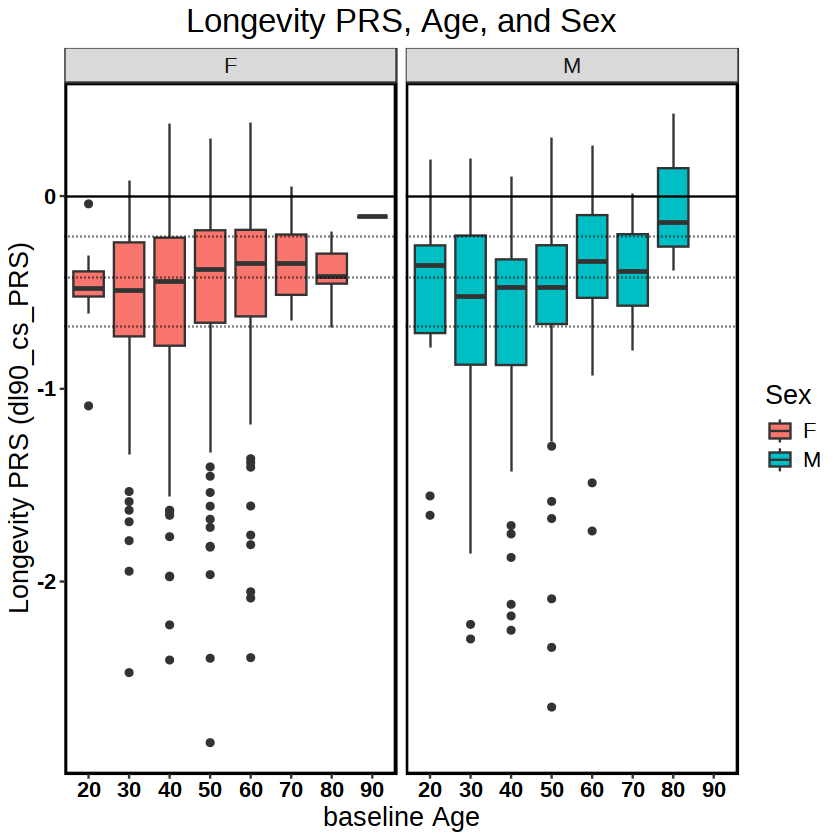

In [876]:
groupWidth <- 10
ageGroup <- groupWidth*round(mix_bl_fi_dat_prs$age/groupWidth)
# PRS distribution by sex
#ggplot(data = mix_bl_fi_dat_prs,
#      aes(x = dl90_cs,
#         color = ageGroup)) +
#        geom_boxplot() +
#    labs(x = "dl90_cs_PRS",
#        y = "Density")
ggplot(data = mix_bl_fi_dat_prs,
       aes(x    = as.factor(ageGroup),
           y    = dl90_cs,
           fill = as.factor(sex))) +
       geom_boxplot() +
       labs(x    = "baseline Age", 
            y    = "Longevity PRS (dl90_cs_PRS)") +
       facet_wrap(~ as.factor(sex)) +
       geom_hline(yintercept = 0) +
       geom_hline(yintercept = prsQuartiles, linetype = "dotted") +
       labs(fill = "Sex",
            title = "Longevity PRS, Age, and Sex")


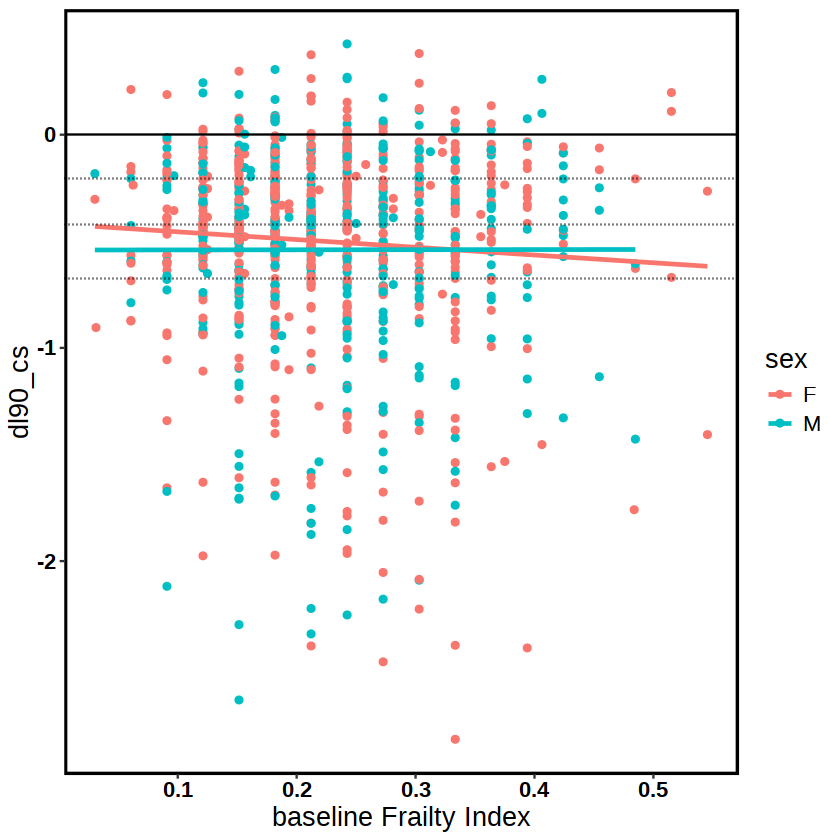

In [875]:
# PRS against baseline FI
ggplot(data = mix_bl_fi_dat_prs,
      aes(x = bl_fi,
          y = dl90_cs,
         color = sex)) +
        geom_point() +
        geom_smooth(method='lm', formula = y ~ x, se = FALSE) +
       geom_hline(yintercept = 0) +
       geom_hline(yintercept = prsQuartiles, linetype = "dotted") +
        labs(x = "baseline Frailty Index")

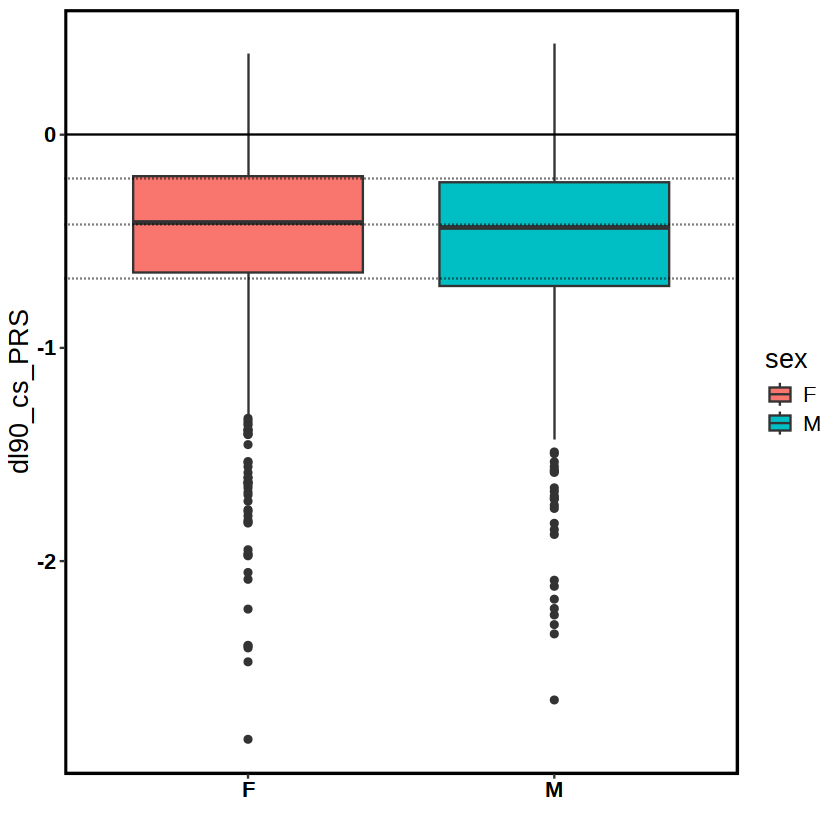

In [877]:
ggplot(data = mix_bl_fi_dat_prs,
      aes(x = sex,
          y = dl90_cs,
          fill = sex)) +
        geom_boxplot() +
       geom_hline(yintercept = 0) +
       geom_hline(yintercept = prsQuartiles, linetype = "dotted") +
    labs(x = "",
        y = "dl90_cs_PRS") ## use quartile cutoffs

In [881]:
# stratification by PRS quantile and sex, including right end (0, 25]
female_prs_quartile = merge(mix_bl_fi_dat, dl90cs_prs, by = "public_client_id") %>%
                    dplyr::select(public_client_id, dl90_cs, sex) %>%
                    filter(sex == "F") %>%
                    distinct() %>%
                    mutate(quartile = case_when(
                        dl90_cs <= quantile(.$dl90_cs, prob = 0.25) ~ "Q1",
                        dl90_cs <= quantile(.$dl90_cs, prob = 0.5) ~ "Q2",
                        dl90_cs <= quantile(.$dl90_cs, prob = 0.75) ~ "Q3",
                        TRUE ~ "Q4",
                    )) # %>%
                    # mutate(sex_quartile = paste0(sex, "_", quartile))

male_prs_quartile = merge(mix_bl_fi_dat, dl90cs_prs, by = "public_client_id") %>%
                    dplyr::select(public_client_id, dl90_cs, sex) %>%
                    filter(sex == "M") %>%
                    distinct() %>%
                    mutate(quartile = case_when(
                        dl90_cs <= quantile(.$dl90_cs, prob = 0.25) ~ "Q1",
                        dl90_cs <= quantile(.$dl90_cs, prob = 0.5) ~ "Q2",
                        dl90_cs <= quantile(.$dl90_cs, prob = 0.75) ~ "Q3",
                        TRUE ~ "Q4",
                    )) # %>%
                    # mutate(sex_quartile = paste0(sex, "_", quartile))
mix_prs_quartile = rbind(female_prs_quartile, male_prs_quartile) %>% as.data.frame() %>%
                   dplyr::select(public_client_id, quartile, sex)

mix_prs_for_est = merge(mix_id_pred, mix_prs_quartile, by = "public_client_id") %>% 
                  as.data.frame() 
# female, n = 804; male, n = 580

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


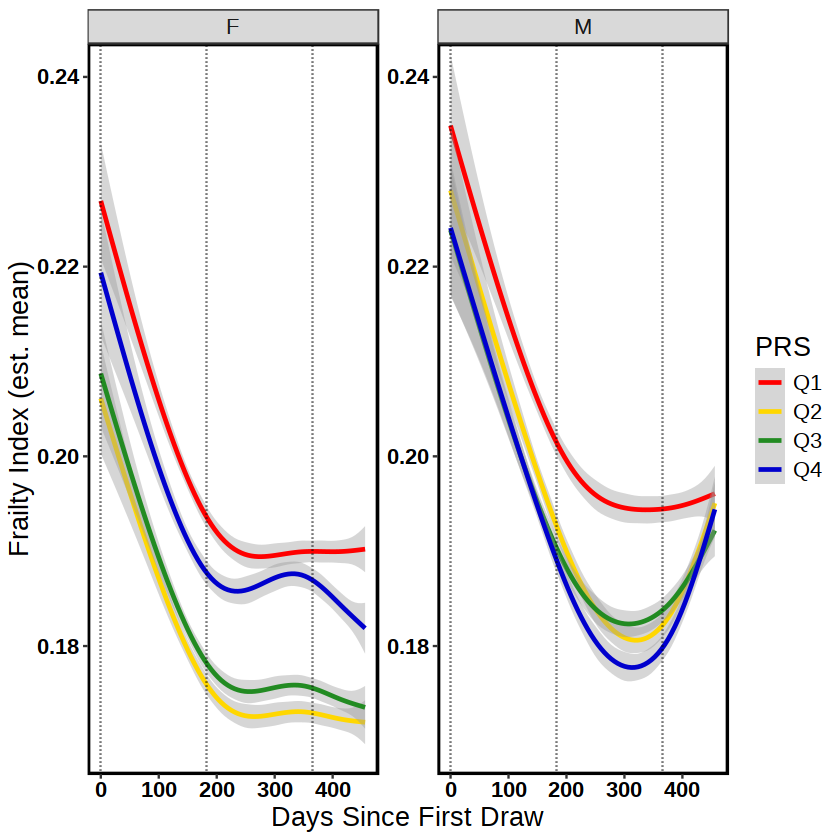

In [911]:
options(jupyter.plot_scale=1,
        width=200,
        repr.matrix.max.cols=200,
        repr.matrix.max.rows=Inf)
ggplot(data = mix_prs_for_est,
       aes(x = days_since_first_draw,
           y = as.numeric(est))) +
        scale_color_manual(values=c("Red","Gold","ForestGreen","MediumBlue")) +
        geom_smooth(aes(group = as.factor(quartile),
                        color = as.factor(quartile)),
                    method="gam") +
        coord_cartesian(ylim = c(0.17,0.24)) +
        facet_wrap(.~ sex, scale = "free") +
        geom_vline(xintercept = c(0:2)*halfYear, linetype = "dotted") +
        labs(x = "Days Since First Draw",
             y = "Frailty Index (est. mean)",
             color = "PRS") ## change to percentage change

## ldl PRS from snapshot

### Longitudinal association of proteins/metabolites (baseline) with lab FI

In [883]:
# import eigenvalue
prot_ev = read.csv("./Protein_module_eigenvalues.tsv", sep = "\t")
metab_ev = read.csv("./Metabolite_module_eigenvalues.tsv", sep = "\t")
multiomics_ev = read.csv("./Multiomic_module_eigenvalues.tsv", sep = "\t")

In [884]:
# merge longitudinal fi with eigenvalue; scale
selected_colnames = c("PC1", "PC2", "PC3", "PC4", 
                      "t1", "t2", "t3", "base_age", colnames(multiomics_ev)[-1]) 
glmm_formula = "lab_fi ~"
for (i in selected_colnames) {glmm_formula = paste(glmm_formula, i, "+")}
glmm_formula = paste0(glmm_formula, "(1 + t1 |`public_client_id`)")
mix_bl_fi_dat = rbind(female_bl_fi_dat_all, male_bl_fi_dat_all) %>% as.data.frame()
mix_bl_fi_multi_dat = merge(mix_bl_fi_dat, multiomics_ev, by = "public_client_id") %>%
                      dplyr::mutate_at(colnames(multiomics_ev)[-1], ~scale(.)[, 1])

In [885]:
id_lst = list(unique(female_below55_dat$'public_client_id'),
           unique(female_above55_dat$'public_client_id'),
           unique(male_below55_dat$'public_client_id'),
           unique(male_above55_dat$'public_client_id'))
longit_FI_multi_models = lapply(c(1:4), function(x) {
    dat = mix_bl_fi_multi_dat %>% 
          filter(`public_client_id` %in% id_lst[[x]])
    lmm_res = glmer(as.formula(glmm_formula), family = Gamma(link = "log"), 
                 data = dat, glmerControl(nAGQ0initStep = FALSE))
    return(lmm_res)
})

Warning message in (function (fn, par, lower = rep.int(-Inf, n), upper = rep.int(Inf, :
“failure to converge in 10000 evaluations”
Warning message in optwrap(optimizer, devfun, start, rho$lower, control = control, :
“convergence code 4 from Nelder_Mead: failure to converge in 10000 evaluations”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 23.2874 (tol = 0.002, component 1)”
Warning message in (function (fn, par, lower = rep.int(-Inf, n), upper = rep.int(Inf, :
“failure to converge in 10000 evaluations”
Warning message in optwrap(optimizer, devfun, start, rho$lower, control = control, :
“convergence code 4 from Nelder_Mead: failure to converge in 10000 evaluations”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: dege

In [746]:
new_time_multi = rbind(female_below55_dat) %>%
           as.data.frame() %>%
           dplyr::select(days_since_first_draw, t1, t2, t3) %>%
           distinct() %>%
           arrange(days_since_first_draw)

id_included_model = lapply(longit_FI_multi_models, function(x){
    unique(rownames(ranef(x)$public_client_id))
})

id_pred_dat = lapply(1:4, function(x) {
    distinct = mix_bl_fi_multi_dat %>%
               filter(public_client_id %in% id_included_model[[x]]) %>%
               dplyr::select(public_client_id, base_age, PC1, PC2, PC3, PC4, colnames(multiomics_ev)[-1]) %>%
                     distinct()
    forpred = distinct %>%
              dplyr::slice(rep(1:n(), each = nrow(new_time_multi))) %>%
              cbind(., new_time_multi[rep(1:nrow(new_time_multi), length(id_included_model[[x]])), ]) %>%
              as.data.frame()
    return(forpred)
})

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


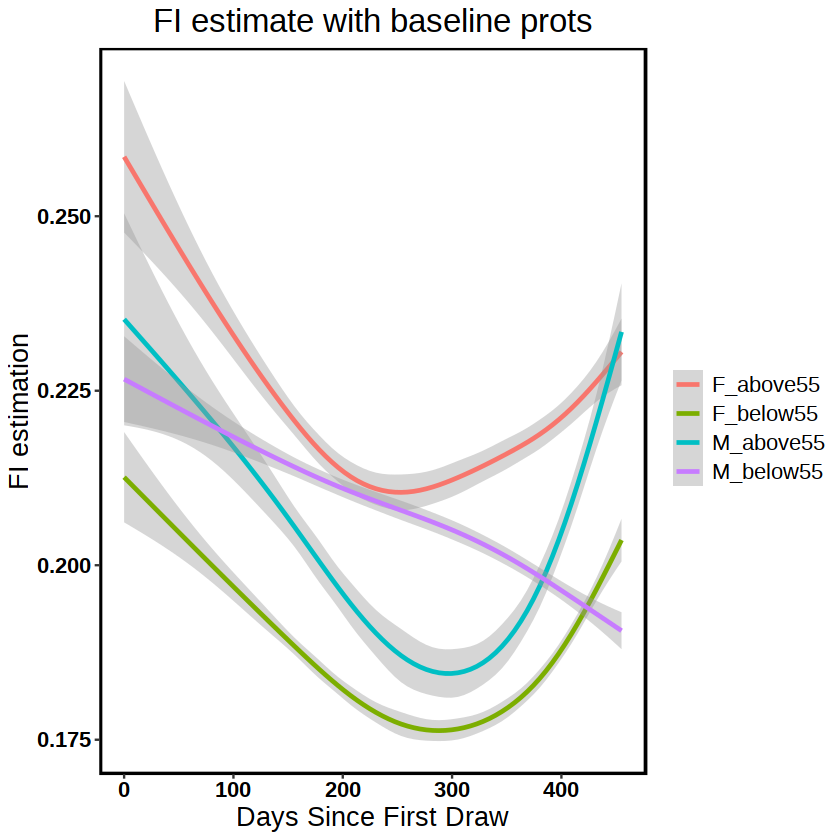

In [750]:
type_lst = c("F_below55", "F_above55", "M_below55", "M_above55")
each_dat_est = lapply(1:4, function(x) {
    dat_est = id_pred_dat[[x]] %>%
            mutate(est = exp(predict(longit_FI_multi_models[[x]], newdata = id_pred_dat[[x]][, -46])),
                  type = rep(type_lst[[x]], nrow(.)))
})
mix_multi_est = Reduce(rbind, each_dat_est) %>% as.data.frame()
ggplot(data = mix_multi_est,
       aes(x = days_since_first_draw,
           y = as.numeric(est))) +
        geom_smooth(aes(group = as.factor(type),
                       color = as.factor(type))) +
    labs(x = "Days Since First Draw",
        y = "FI estimation",
        color = "") +
    ggtitle("FI estimate with baseline prots")

In [751]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/arivale-r/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8    LC_PAPER=en_US.UTF-8      
 [8] LC_NAME=C                  LC_ADDRESS=C               LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] BiocParallel_1.24.1 caret_6.0-92        caTools_1.18.2      plyr_1.8.7          mixOmics_6.18.1     lattice_0.20-45     MASS_7.3-57         ggfortify_0.4.16    nlme_3.1-157       
[10] lme4_1.1-29         Matrix_1.4-1        ggplot2_3.5.0       dplyr_1.1.4        

loaded via a namespace (and not attached):
 [1] bitop